In [1]:
from multiprocessing import Pool, cpu_count
import gc; gc.enable()
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn import *
import sklearn


E:\anacoda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


E:\anacoda\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
E:\anacoda\lib\site-packages\sklearn\lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
E:\anacoda\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
E:\anacoda\lib\site-packages\sklearn\qda.py:6: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19."

In [2]:
def transform_df(df):
    df = pd.DataFrame(df)
    df = df.sort_values(by=['date'], ascending=[False])
    df = df.reset_index(drop=True)
    df = df.drop_duplicates(subset=['msno'], keep='first')
    return df

def transform_df2(df):
    df = df.sort_values(by=['date'], ascending=[False])
    df = df.reset_index(drop=True)
    df = df.drop_duplicates(subset=['msno'], keep='first')
    return df


In [3]:
train = pd.read_csv("G:\PythonProjects\KaggleOrOthersJourney/train_aft_process.csv")

In [4]:
test = pd.read_csv("G:\PythonProjects\KaggleOrOthersJourney/test_aft_process.csv")

In [5]:
# user_logs_all = pd.DataFrame()
# for i in range(1,80):
#     user_logs = pd.read_csv(
#         "G:\PythonProjects\KaggleOrOthersJourney\WSDM-KKBox'sChurnPredictionChallenge\data/user_log_split_"+str(i)+".csv"
#     )
#     # user_logs = pd.concat(user_logs, axis=0, ignore_index=True).reset_index(drop=True)
#     user_logs = transform_df2(user_logs)
#     user_logs_all = pd.merge(user_logs_all, user_logs, on='msno', how='left').reset_index(drop=True)
#     user_logs_all = transform_df2(user_logs_all)

In [6]:
train = train.fillna(0)
test = test.fillna(0)

In [7]:
cols = [c for c in train.columns if c not in ['is_churn','msno']]

In [8]:
def xgb_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'log_loss', metrics.log_loss(labels, preds)

In [13]:
fold = 1
for i in range(fold):
    params = {
        'eta': 0.02, #use 0.002
        'max_depth': 7,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'seed': i,
        'silent': True
    }
    x1, x2, y1, y2 = model_selection.train_test_split(train[cols], train['is_churn'], test_size=0.3, random_state=i)
    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
    model = xgb.train(params, xgb.DMatrix(x1, y1), 150,  watchlist, feval=xgb_score, maximize=False, verbose_eval=50, early_stopping_rounds=1500) #use 1500
    if i != 0:
        pred += model.predict(xgb.DMatrix(test[cols]), ntree_limit=model.best_ntree_limit)
    else:
        pred = model.predict(xgb.DMatrix(test[cols]), ntree_limit=model.best_ntree_limit)
pred /= fold

[0]	train-log_loss:0.673347	valid-log_loss:0.673347


Multiple eval metrics have been passed: 'valid-log_loss' will be used for early stopping.



Will train until valid-log_loss hasn't improved in 1500 rounds.


[50]	train-log_loss:0.197723	valid-log_loss:0.197723


[100]	train-log_loss:0.068188	valid-log_loss:0.068188


In [14]:
test['is_churn'] = pred.clip(0.0000001, 0.999999)

In [15]:
test[['msno','is_churn']].to_csv('submission4.csv.gz', index=False, compression='gzip')

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [17]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)

In [22]:
# xgb.plot_importance(booster=model);

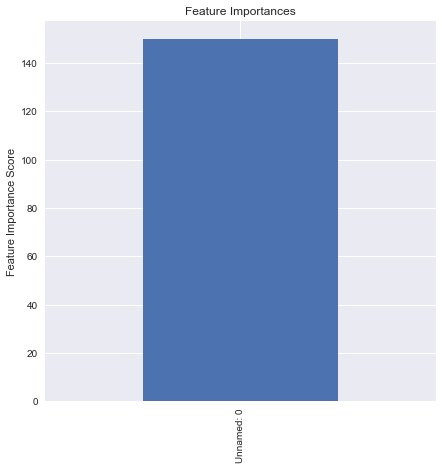

In [23]:
# 打印特征重要性
# feat_imp = pd.Series(model.get_fscore()).sort_values(ascending=False) 
# feat_imp.plot(kind='bar', title='Feature Importances') 
# plt.ylabel('Feature Importance Score')
